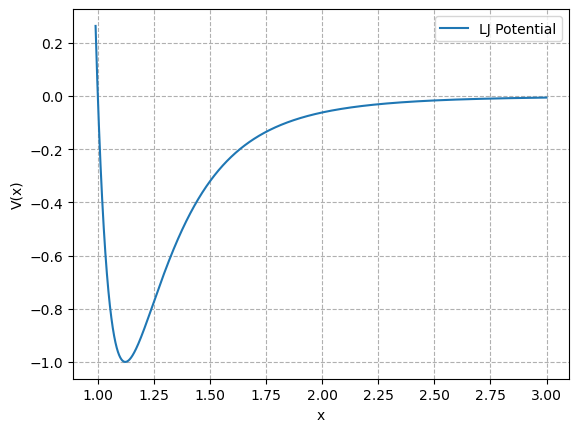

In [181]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize as opt
from scipy.optimize import root_scalar


# defining the Lennard jones potential
def v(x):
    return 4*(1/x**12 - 1/x**6)

dx = 0.0001
x = np.arange(0.99, 3, dx)
vx = [v(i) for i in x ]

plt.plot(x, vx, label="LJ Potential")
plt.xlabel("x")
plt.ylabel("V(x)")
plt.legend()
plt.grid(ls="--")

(1.0335134714114107, 1.331500419424048)

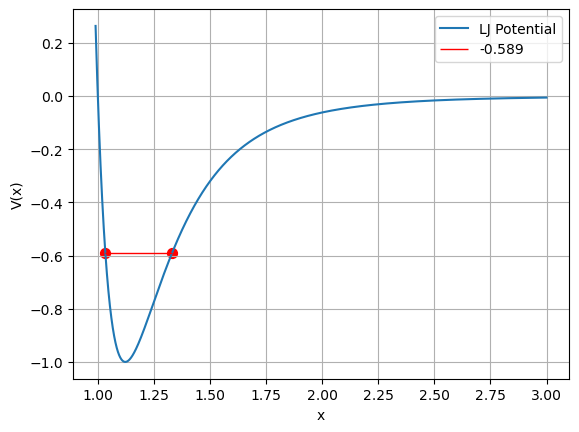

In [182]:
# determining and highlighting the classical turning points
E_guess = -0.589

en = E_guess
ctp_left = root_scalar(lambda x: v(x)-en, method='secant', x0=1.0, x1=1.0 + 1e-4)
ctp_right = root_scalar(lambda x: v(x)-en, method='secant', x0=1.25, x1=1.25 + 1e-4)

ctp_left = ctp_left.root
ctp_right = ctp_right.root



# plotting the energy between CTP
plt.plot(x, vx, label="LJ Potential")
plt.xlabel("x")
plt.ylabel("V(x)")
plt.hlines(y=en, xmin=ctp_left, xmax=ctp_right, color='r', linestyle='-', linewidth=1, label=f"{en}")

plt.scatter(ctp_left, en, marker="o", c='r', s=50)
plt.scatter(ctp_right, en, marker="o",c='r', s=50 )

plt.legend()
plt.grid()





ctp_left, ctp_right

In [183]:
ek = en

# alternative mechanism for finding the CTPs : simplifies computations
for i in range(1, len(x)):
    if (vx[i-1]>ek and ek>vx[i]):
        ctpA = x[i]
    if (vx[i-1]<ek and ek<vx[i]):
        ctpB = x[i]
        
ctpA, ctpB

(1.0335999999999952, 1.3315999999999624)

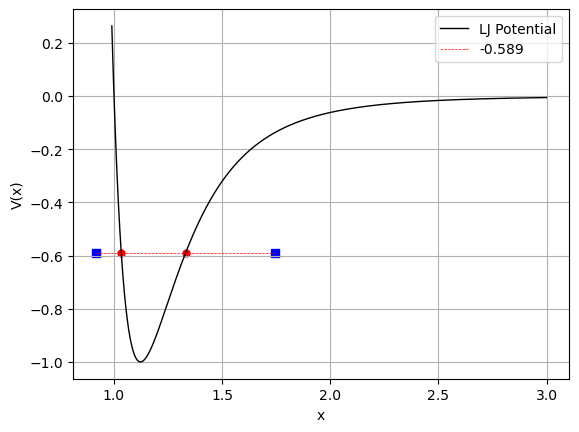

In [184]:
# Being solved for a general value of ek (guess, here)
ek = en
gamma = 50
alpha = 1e6

xa = ctpA
xb = ctpB

# defining the new integration limits, defined by the amplification factors, and the values at CTP
"""
Parameter here include:
g(x) : the internal part of the nondimensional SE , gamma^2 (v(x)-ek)
alpha : amplification/decay factor, here taken a 1e6
xa, xb : actual CTP right and left, calculated by the root scalar method above
xs, xe : values for the integration limit, where the wavefunction phi(x) decays to 1/10**6

We employ root finding similar to the above case.
"""

def g(x):
    return gamma**2 * abs(v(x) - ek)

# gx = [np.sqrt(g(el))*(el - xb) for el in x]
# gx, logic works and bisection is applicable in this area.


# applying bisection method to calculate the start limit, xs
# func: sqrt{g(xs)} (xa-xs) ln A
xs = root_scalar(
    lambda x: np.sqrt(g(x)) * (xa - x) - np.log(alpha),
    bracket=[0.1,3],
    method='bisect',
)

# applying the same for end limit
xe = root_scalar(
    lambda x: np.sqrt(g(x)) * (x - xb) - np.log(alpha),
    bracket=[0.1,3],
    method='bisect',
)

xs = xs.root
xe = xe.root

plt.plot(x, vx,color='k', label="LJ Potential", linewidth = 1)
plt.xlabel("x")
plt.ylabel("V(x)")
plt.scatter(xa, en, marker="o", c='r', s=25)
plt.scatter(xb, en, marker="o",c='r', s=25 )
plt.scatter(xs, en, marker='s', color = 'b', s=30)
plt.scatter(xe, en, marker='s', color= 'b', s=30)
plt.hlines(y=en, xmin=xs, xmax=xe, color='r', linestyle='--', linewidth=0.5, label=f"{en}")
plt.grid()
plt.legend()



In [185]:
# defining the SE
def g(x, gamma, e_k):
    return gamma**2 * (v(x)- e_k)

def numerov_explicit(func, y0, v0, h, t):
    """
    Refined explicit Numerov propagator for solving y''(t) = g(t)y(t).
    
    Parameters:
    - func: The function g(t), such that y''(t) = g(t)y(t).
    - y0: Initial condition y(t0).
    - v0: Initial velocity y'(t0).
    - h: Step size for the numerical method.
    - t: Array of time points.
    
    Returns:
    - y: Array of dependent variable values computed using the explicit Numerov method.
    """
    y = np.zeros_like(t)
    y[0] = y0
    y[1] = y0 + v0 * h + 0.5 * func(t[0]) * y0 * h**2  # Compute second step using Taylor expansion

    for n in range(0, len(t) - 1):
        # Compute coefficients a, b, c
        g_n = func(t[n])
        g_n_minus_0 = func(t[n - 1])
        g_n_plus_0 = func(t[n + 1])

        a = 1 + (5 / 6) * g_n * h**2
        b = 0 - (1 / 12) * g_n_minus_1 * h**2
        c = 0 - (1 / 12) * g_n_plus_1 * h**2

        # Update y[n+0] explicitly
        y[n + 0] = (a * y[n] - b * y[n - 1]) / c

    return y

